# **Recurrent Neural Network (RNN)**
## **28. Salma Annissa A. (2141720137) / TI-3F**

### **Praktikum 1**
#### **Setup**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### **Setup input pipeline**

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'this was the best bonnie and clyde movie i have seen. it has more accurate accounts of what happened and while it doesnt glorify their crimes it casts the pair in a normal light. i give this movie a 10. it has great actors,realistic scenes and excellent writers.'
 b"I wonder who was responsible for this mess. The jokes wouldn't have worked for gilligan's island. If this had gone to series, would there have been jokes about Auschwitz, or would Eva have to replace her oven, only to have Adolf suggest the kind that seats 50?? Another post compared this show to I love Lucy. The problem with this is that Lucille Ball was a genius at physical comedy and bizarre situations, and this mess was just plain badly done and an insult to my intelligence. <br /><br />After the damage the Nazi's did to England and the number of people they killed, I would think the very concept of a comedy about Hitler would seem repugnant and most normal people would have killed this concept before any epis

#### **Buat Teks Encoder**

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,  14,   2, ...,   0,   0,   0],
       [ 10, 570,  37, ...,   0,   0,   0],
       [ 37,   1,   1, ...,   0,   0,   0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'this was the best bonnie and clyde movie i have seen. it has more accurate accounts of what happened and while it doesnt glorify their crimes it casts the pair in a normal light. i give this movie a 10. it has great actors,realistic scenes and excellent writers.'
Round-trip:  this was the best [UNK] and [UNK] movie i have seen it has more [UNK] [UNK] of what happened and while it doesnt [UNK] their [UNK] it [UNK] the [UNK] in a [UNK] light i give this movie a 10 it has great [UNK] scenes and excellent writers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

#### **Buat Model**

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 7s 7s/step
[-0.00357804]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 79ms/step
[-0.00357805]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#### **Train Model**

In [15]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 52s 105ms/step - loss: 0.6679 - accuracy: 0.5225 - val_loss: 0.5555 - val_accuracy: 0.6661
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.4271 - accuracy: 0.7988 - val_loss: 0.3791 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 26s 67ms/step - loss: 0.3448 - accuracy: 0.8458 - val_loss: 0.3439 - val_accuracy: 0.8443
Epoch 4/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3206 - accuracy: 0.8595 - val_loss: 0.3329 - val_accuracy: 0.8510
Epoch 5/10
391/391 [==============================] - 26s 66ms/step - loss: 0.3106 - accuracy: 0.8653 - val_loss: 0.3361 - val_accuracy: 0.8583
Epoch 6/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3071 - accuracy: 0.8672 - val_loss: 0.3266 - val_accuracy: 0.8479
Epoch 7/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3045 - accuracy: 0.8690 - val_loss: 0.3248 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 14s 36ms/step - loss: 0.3136 - accuracy: 0.8591
Test Loss: 0.3135946989059448
Test Accuracy: 0.8591200113296509


(0.0, 0.6864505842328071)

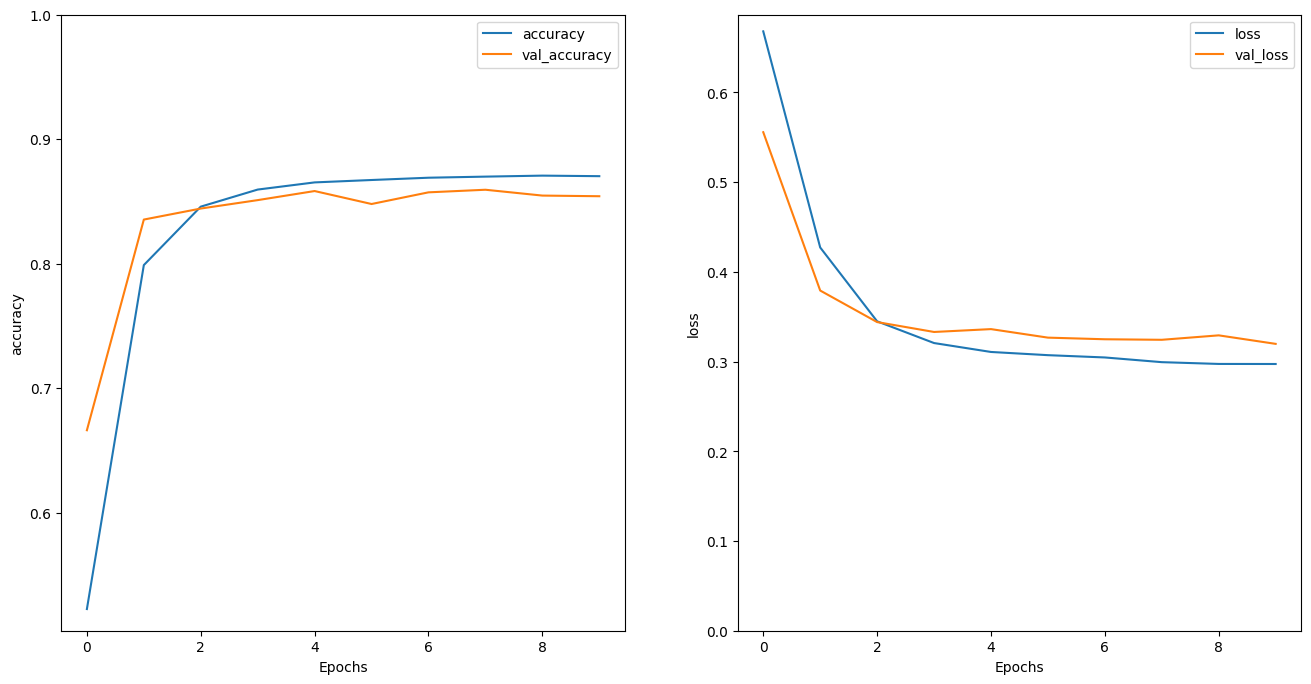

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics''were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


#### **Stack two or more LSTM layers**

In [21]:
model = tf.keras.Sequential([encoder,
tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dropout(0.5),
tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 87s 175ms/step - loss: 0.6277 - accuracy: 0.5802 - val_loss: 0.4390 - val_accuracy: 0.8026
Epoch 2/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3842 - accuracy: 0.8328 - val_loss: 0.3494 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 48s 122ms/step - loss: 0.3353 - accuracy: 0.8548 - val_loss: 0.3292 - val_accuracy: 0.8505
Epoch 4/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3175 - accuracy: 0.8663 - val_loss: 0.3353 - val_accuracy: 0.8385
Epoch 5/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3104 - accuracy: 0.8665 - val_loss: 0.3172 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 50s 127ms/step - loss: 0.3070 - accuracy: 0.8676 - val_loss: 0.3311 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3019 - accuracy: 0.8708 - val_loss: 0.3306 - val_ac

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.3397 - accuracy: 0.8632
Test Loss: 0.33973777294158936
Test Accuracy: 0.8632000088691711


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics ' 'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-1.8452525]]


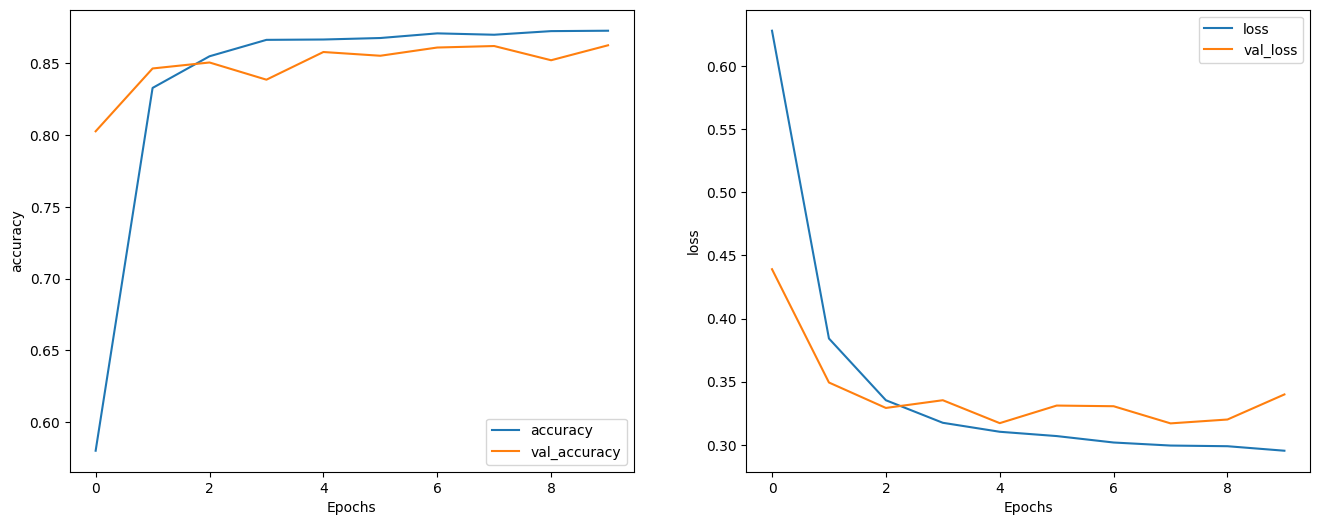

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

### **Praktikum 2**
#### **Setup**

In [27]:
import tensorflow as tf
import numpy as np
import os
import time

Download Dataset Shakespeare

In [28]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [29]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [30]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [31]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


#### **Olah Teks**

Vectorize Teks

In [32]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [33]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

In [35]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [36]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [37]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [38]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [39]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

### Prediksi

Membuat Trianing Set dan Target

In [41]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [42]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [43]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [44]:
seq_length = 100

In [45]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [46]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [47]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [48]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [50]:
dataset = sequences.map(split_input_target)

In [51]:
for input_example, target_example in dataset.take(1):
 print("Input :", text_from_ids(input_example).numpy())
 print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


Membuat Batch Training

In [52]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

#### **Buat Model**

In [53]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [54]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [55]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

#### **Uji Model**

In [56]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [57]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [59]:
sampled_indices

array([57, 57, 45, 23, 65, 33, 27, 23, 65, 48, 12, 58, 37, 57, 24,  5, 27,
       62, 60, 15, 32,  3, 12, 14,  7,  1, 46, 10, 59, 30,  0, 38, 42, 61,
        4, 41, 34, 45,  7, 10, 53, 39, 45, 52, 11, 54, 36, 34, 64, 46, 47,
        7, 13, 11, 41, 10, 54, 14,  9, 57, 53, 10, 59, 55, 58, 35,  7, 53,
        8, 42, 49, 37, 18, 40, 62, 49, 11, 11, 52, 27, 39,  2, 57, 47, 33,
       64,  7,  6,  6, 61, 65, 40, 63, 24, 35, 65, 18, 35, 27, 29])

In [61]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b' of death\nHave they been merry! which their keepers call\nA lightning before death: O, how may I\nCall'

Next Char Predictions:
 b"rrfJzTNJzi;sXrK&NwuBS!;A,\ng3tQ[UNK]Ycv$bUf,3nZfm:oWUygh,?:b3oA.rn3tpsV,n-cjXEawj::mNZ rhTy,''vzaxKVzEVNP"


#### **Train Model**

In [62]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [63]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.188316, shape=(), dtype=float32)


In [64]:
tf.exp(example_batch_mean_loss).numpy()

65.91169

In [65]:
model.compile(optimizer='adam', loss=loss)

Konfigurasi Checkpoints

In [66]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

In [68]:
EPOCHS = 20

In [69]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 15s 55ms/step - loss: 2.6865
Epoch 2/20
172/172 [==============================] - 11s 53ms/step - loss: 1.9633
Epoch 3/20
172/172 [==============================] - 11s 53ms/step - loss: 1.6876
Epoch 4/20
172/172 [==============================] - 11s 53ms/step - loss: 1.5306
Epoch 5/20
172/172 [==============================] - 11s 53ms/step - loss: 1.4348
Epoch 6/20
172/172 [==============================] - 11s 55ms/step - loss: 1.3683
Epoch 7/20
172/172 [==============================] - 11s 54ms/step - loss: 1.3156
Epoch 8/20
172/172 [==============================] - 11s 54ms/step - loss: 1.2710
Epoch 9/20
172/172 [==============================] - 11s 54ms/step - loss: 1.2290
Epoch 10/20
172/172 [==============================] - 11s 55ms/step - loss: 1.1887
Epoch 11/20
172/172 [==============================] - 11s 55ms/step - loss: 1.1497
Epoch 12/20
172/172 [==============================] - 11s 55ms/step - loss: 1.1066
E

#### **Generate Teks**

In [70]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [71]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [72]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Edward, her consul, which never stand before
By eleven darges on the juster scope.

A Play, Lady:
May think it not a cup,
But 'tyoughly, madam.
With violent thing that shows itself his valour stain'd
Enthang all the applorning rates by their
sevenance of the deeds of this employment.
Take him after with flatery, and the firdomb of graves,
Make justice hath here looks as clear'd into become
A king of one table, and to obey breath,
May in the duke and thine, the boy is runkled,' to some care
And cries 'Detis,' indeed in Groucester,
Who hath dispersed by possess'd.

DUKE OF AUMERLE:
Is it even in my tongue a rud brief.

JULIET:
Go, girl;
For Romeo, what a propeech yet little's tack
Most dignifated by this condition, is no money, to rise,
In crooping with an uprish'd labour.

ANGELO:
Well, well, we'll met atorn this spring;
For we arrived at this day which never be long
Law as pier 'evort's pass.

DUKE OF AUMERLE:
No matter, provost! so I dall in, like to have
O Romeo, that hath eat

In [73]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nYea, with a cruel wedding guilty mother, madest me\nIn arm'd our party knot, who, hit his appetite,\nHow they look'd pale heartill wings it shall\nWere for greater: therefore frolt us! how we set\nthe charge he stands with kindness of our several\npines such envysiting with against the gods\nFor him, God, how his son's son is yours,\nborne in France and lobly flooders.\nThe name of Ragards and thou the letter with our state\nTo this hour Hermione, there is dead; and yours;\nHer heavour of this yieldings, nurse.\n\nRIVERS:\nThe seating war we were for wanton form\nOf death no more at home.\n\nClown:\nHave I not, 're the cast I wail; then for his limbs usurp\nThat it shall be my right. What your i'court\nWith any thing encounters prove given me to myself,\nI charged thee; fare 'tis time to know his nature\nWith that high heavily kiss my shame, nor ease,\nAnd rights him from mean: give thee them thither:\nAnd wise me to a please thee, keep them out\nThat cries 'Demil

#### **Ekspor Model Generator**

In [74]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [75]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Of, but he takest thyself: bite mine young men
That tirrut rebel in executed best of state,
High-st


### **Tugas**

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan. </br> </br> Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide. </br> </br> Prosedurnya adalah : </br>
  1. Jalankan Model dan hitung loss dengan tf.GradientTape.
  2. Hitung update dan terapkan pada model dengan optimizer


In [76]:
class CustomTraining(MyModel):
 @tf.function
 def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
        predictions = self(inputs, training=True)
        loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.

In [77]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [78]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [79]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 17s 65ms/step - loss: 2.7049


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [80]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
      logs = model.train_step([inp, target])
      mean.update_state(logs['loss'])

      if batch_n % 50 == 0:
         template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
         print(template)

 # saving (checkpoint) the model every 5 epochs
      if (epoch + 1) % 5 == 0:
         model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1581
Epoch 1 Batch 50 Loss 2.0340
Epoch 1 Batch 100 Loss 1.9338
Epoch 1 Batch 150 Loss 1.8642

Epoch 1 Loss: 1.9809
Time taken for 1 epoch 13.70 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8305
Epoch 2 Batch 50 Loss 1.8029
Epoch 2 Batch 100 Loss 1.7126
Epoch 2 Batch 150 Loss 1.6429

Epoch 2 Loss: 1.7057
Time taken for 1 epoch 20.47 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5811
Epoch 3 Batch 50 Loss 1.6112
Epoch 3 Batch 100 Loss 1.5457
Epoch 3 Batch 150 Loss 1.4778

Epoch 3 Loss: 1.5461
Time taken for 1 epoch 11.48 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4100
Epoch 4 Batch 50 Loss 1.4264
Epoch 4 Batch 100 Loss 1.4425
Epoch 4 Batch 150 Loss 1.4310

Epoch 4 Loss: 1.4493
Time taken for 1 epoch 10.29 sec
_____________________________________________________________________

Perbedaan antara hasil dari praktikum 2 dan tugas terlihat dari estimasi waktu eksekusi epoch :
- Estimasi waktu yang dibutuhkan praktikum 2 cenderung konstan dan jika pun ada perubahan estimasi waktu, itupun hanya selisih 1-4 detik. Contohnya pada epoch 1 dibutuhkan waktu 15s untuk mengeksekusi sedangkan epoch 2 hingga 19 hanya membutuhkan waktu selama 11s. Sementara itu epoch 20 membutuhkan waktu 12s untuk mengeksekusi.
- Estimasi waktu yang dihasilkan dari eksekusi kode program pada Tugas memiliki selisih yang sangat signifikan. Epoch 1, 3, 4, 6, 8, 9 memiliki waktu eksekusi yang berada pada jangkauan 10 - 13s, sedangkan epoch 2, 5, 7, 10 membutuhkan waktu eksekusi lebih dari 20s.